In [ ]:
Task : Sentiment Analysis on Amazon Product Reviews.
 
Dataset : https://drive.google.com/file/d/1U4dXjJde2AYJA6oqLyUQha5-6e0Fvi-l/view?usp=sharing
 
Requirements:
 
1. Conduct sentiment analysis on the provided dataset, categorizing reviews as positive, negative, or neutral.
 
2. Adhere to coding standards throughout the implementation.
 
3. Perform exploratory data analysis (EDA) on the dataset.
 
4. Submit the code through a Jupyter notebook, which must include comprehensive comments explaining the code.
 
5. Evaluate the model using various metrics (accuracy, precision, recall, F1 score) to ensure its effectiveness and efficiency.
 
NOTE: YOU NEED TO SUBMIT IT BY 20-FEB-2024 3:00PM
        
- Write justifications
- Best practices
- Perform EDA
- Jupyter NB works
- Evaluation Metrics Justification


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import re
from tqdm import tqdm
#importing nltk specific stuff
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

#importing sklearn
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

import string
import swifter
# nltk.download('stopwords')
# nltk.download('punkt')
import warnings
warnings.filterwarnings('ignore')

In [5]:
#reading the input data of amazon product reviews
df = pd.read_csv("amazon_ds.csv")
print(df.shape)
df.head()

(1766992, 2)


,review_body,star_rating
0,so beautiful even tho clearly not high end ......,5
1,"Great product.. I got this set for my mother, ...",5
2,Exactly as pictured and my daughter's friend l...,5
3,Love it. Fits great. Super comfortable and nea...,5
4,Got this as a Mother's Day gift for my Mom and...,5


In [6]:
df.tail()

,review_body,star_rating
1766987,It is nice looking and everything (it is sterl...,4.0
1766988,"my boyfriend bought me this last christmas, an...",4.0
1766989,This is a great way to quickly start learning ...,4.0
1766990,the 14kt gold earrings look remarkable...would...,5.0
1766991,It will be a gift to my special friend. We kno...,5.0


In [7]:
df.isna().sum()

review_body    244
star_rating      9
dtype: int64

In [8]:
df[df.review_body.isna()]

,review_body,star_rating
3818,NaN,4
6480,NaN,5
8956,NaN,5
10875,NaN,5
11013,NaN,1
...,...,...
1514238,NaN,NaN
1598171,NaN,NaN
1607739,NaN,NaN
1661684,NaN,NaN


In [9]:
#removing the null values on review_body level.
df.dropna(subset='review_body', inplace=True)

In [10]:
df[df.review_body.isna()]
df[df.star_rating.isna()]

,review_body,star_rating


In [11]:
df.iloc[[2762,    3564,    4298,    4514,    5284,    5855,    6394,
              10233,   15029,   15288,
             904111,  904502,  905119,  907751,  910790,  964064,  972967,
            1072585, 1669522, 1691612]]

,review_body,star_rating
2762,:),5
3564,:),4
4299,:),5
4515,:),5
5285,:),5
5856,It is what it is,2
6395,:),4
10236,:),4
15036,:),5
15295,So so,3


In [12]:
df.star_rating.value_counts()

5      921893
4      226378
1      135261
3      135139
5      120000
2       85938
5.0     38978
4       33062
3       18485
1       14094
4.0     10984
2       10963
3.0      6030
1.0      5647
2.0      3896
Name: star_rating, dtype: int64

In [13]:
#The ratings are of diff-2 types, to make it consistent, typecasting the ratings to integers
df.star_rating = df.star_rating.astype(float).astype(int)

df.star_rating.value_counts()

5    1080871
4     270424
3     159654
1     155002
2     100797
Name: star_rating, dtype: int64

In [14]:
# df.drop(df[df.star_rating=='2012-12-21'].index, inplace=True)

In [15]:
# Considering 4 & 5 stars as positive.
# 2 & 3 stars as Neutral
# 1 star as Negative

# Positives - 5 -> 1
# Neutral   - 3,4 -> 2
# Negative - 1,2 -> 3

In [16]:
class Utils(object):
    """
        This is the utility class where we have our helper functions
    """
    
    def __init__(self):
        self.porter_stemmer = PorterStemmer()
    
    @staticmethod
    def mapValues(x) -> int:
        """
            Map the 5 categories of star ratings into 3 categories.
            Considering 5 star rated as Positive review, 3 and 4 star rated as Neutral Review and 1 and 2 star rated 
            as Negative Review.
        """
        if x in [1,2]: return 3
        elif x in [3,4] : return 2
        elif x == 5: return 1
        
    def preprocessText(self, review: str) -> str:
        """
            Preprocessing the raw text
            Steps:
                - Lowering the cases of the text
                - Tokenizing the reviews
                - removing stop words and punctuations
                - Stemming using rule based porterstemmer to come to root form of word, Grammer is not that important in our case as we just want to classify 
                    the reviews      
            return: processed text as string
        """

        review = review.lower().replace(".", "").strip() #converting string to lower case


        tokenized_words = word_tokenize(review) # applying word tokenizer

#         #Removing stop words and punctuations
        tokenized_words = [token for token in tokenized_words if token not in stopwords.words('english') and token not in list(string.punctuation)]
#         #Applying porter stemmer on each token to come up with the root word of each token
        clean_review = " ".join([self.porter_stemmer.stem(token) for token in tokenized_words])
        yield clean_review  



In [17]:
utils = Utils()

In [18]:
# calling the method to map the ratings into three categories (Positive :1, Neutral:2, Negative:3)
df.star_rating = df.star_rating.apply(utils.mapValues)
category_counts = df.star_rating.value_counts()
category_counts

1    1080871
2     430078
3     255799
Name: star_rating, dtype: int64

In [116]:
print("Positives: ", round((category_counts[1]/category_counts.sum())*100, 2))
print("Neutral: ", round((category_counts[2]/category_counts.sum())*100, 2))
print("Negatives: ", round((category_counts[3]/category_counts.sum())*100, 2))

Positives:  61.18
Neutral:  24.34
Negatives:  14.48


([<matplotlib.patches.Wedge at 0x22cc0187e50>,
 [Text(-0.3784115788872372, 1.0328623707755398, 'Positive'),
  Text(-0.1138344355323356, -1.0940940184860872, 'Neutral'),
  Text(0.9881565894706147, -0.4832665462100635, 'Negative')],
 [Text(-0.2064063157566748, 0.5633794749684762, '61.2%'),
  Text(-0.06209151029036487, -0.5967785555378657, '24.3%'),
  Text(0.5389945033476079, -0.2635999342963982, '14.5%')])

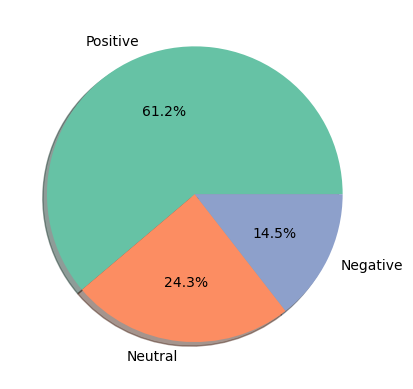

In [117]:
fig, ax = plt.subplots()
labels = ['Positive', 'Neutral', 'Negative']
ax.pie([df.star_rating.value_counts()[1], df.star_rating.value_counts()[2], df.star_rating.value_counts()[3]],
      shadow=True, colors=sb.color_palette("Set2"), labels=labels, autopct='%1.1f%%')

<b>Observation:
- Reviews are Imbalanced in nature, the model is tend to focus more on majority class i.e Positive class.


## Text Preprocessing

In [82]:
#lowering the case
df.review_body[0].lower()

'so beautiful even tho clearly not high end ... but super great for price and as costume jewelry, though others will have to look twice since they appear very near real ... very nice'

In [83]:
#tokenizing the review on word level
print(len(word_tokenize(df.review_body[0].lower())))
print(word_tokenize(df.review_body[0].lower()))

35
['so', 'beautiful', 'even', 'tho', 'clearly', 'not', 'high', 'end', '...', 'but', 'super', 'great', 'for', 'price', 'and', 'as', 'costume', 'jewelry', ',', 'though', 'others', 'will', 'have', 'to', 'look', 'twice', 'since', 'they', 'appear', 'very', 'near', 'real', '...', 'very', 'nice']


In [84]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [85]:
print(list(string.punctuation))

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [86]:
#removing the stop words
print(len([word for word in word_tokenize(df.review_body[0].lower()) if word not in stopwords.words('english')]))
print([word for word in word_tokenize(df.review_body[0].lower()) if word not in stopwords.words('english')])

23
['beautiful', 'even', 'tho', 'clearly', 'high', 'end', '...', 'super', 'great', 'price', 'costume', 'jewelry', ',', 'though', 'others', 'look', 'twice', 'since', 'appear', 'near', 'real', '...', 'nice']


In [87]:
#removing the punctuation
print(len([word for word in word_tokenize(df.review_body[0].lower()) if word not in list(string.punctuation)]))
print([word for word in word_tokenize(df.review_body[0].lower()) if word not in list(string.punctuation)])

34
['so', 'beautiful', 'even', 'tho', 'clearly', 'not', 'high', 'end', '...', 'but', 'super', 'great', 'for', 'price', 'and', 'as', 'costume', 'jewelry', 'though', 'others', 'will', 'have', 'to', 'look', 'twice', 'since', 'they', 'appear', 'very', 'near', 'real', '...', 'very', 'nice']


In [88]:
# df.review_body = [doc.lower() for doc in df.review_body]

# df.review_body[0].lower().replace(".", "")

In [118]:
df

,review_body,star_rating
0,so beautiful even tho clearly not high end ......,1
1,"Great product.. I got this set for my mother, ...",1
2,Exactly as pictured and my daughter's friend l...,1
3,Love it. Fits great. Super comfortable and nea...,1
4,Got this as a Mother's Day gift for my Mom and...,1
...,...,...
1766987,It is nice looking and everything (it is sterl...,2
1766988,"my boyfriend bought me this last christmas, an...",2
1766989,This is a great way to quickly start learning ...,2
1766990,the 14kt gold earrings look remarkable...would...,1


In [25]:
%%time

# Preprocessing the input reviews by removing stop words and punctuations and performing stemming on each of the tokens.
# This process takes too much of time, Hence, storing the resutls in a  new csv
df.review_body = df.review_body.swifter.apply(lambda x: "".join(list(utils.preprocessText(x))), axis=0)
df

Pandas Apply:   0%|          | 0/1766748 [00:00<?, ?it/s]

CPU times: total: 3h 26min 34s
Wall time: 5h 17min 48s


,review_body,star_rating
0,beauti even tho clearli high end super great p...,1
1,great product got set mother allerg bijoux pro...,1
2,exactli pictur daughter 's friend love came pa...,1
3,love fit great super comfort neat idea fish bo...,1
4,got mother 's day gift mom love realli nice qu...,1
...,...,...
1766987,nice look everyth sterl silver think lose quot...,2
1766988,boyfriend bought last christma 've worn everi ...,2
1766989,great way quickli start learn play countri blu...,2
1766990,14kt gold ear look remarkablewould defint recc...,1


In [36]:
# df.to_csv('Processed_reviews.csv', index=False)

In [52]:
# processed_review = []
# for generator in tqdm(df.review_body):
#     processed_review.append("".join(list(generator)))

# %%time
# reviews_data=[]
# for idx, row in tqdm(df.iterrows()):
#     reviews_data.append((utils.preprocessText(row['review_body']), row['star_rating']))

### Reading the Preprocessed Reviews

In [26]:
reviews = pd.read_csv('Processed_reviews.csv')
reviews

,review_body,star_rating
0,beauti even tho clearli high end super great p...,1
1,great product got set mother allerg bijoux pro...,1
2,exactli pictur daughter 's friend love came pa...,1
3,love fit great super comfort neat idea fish bo...,1
4,got mother 's day gift mom love realli nice qu...,1
...,...,...
1766743,nice look everyth sterl silver think lose quot...,2
1766744,boyfriend bought last christma 've worn everi ...,2
1766745,great way quickli start learn play countri blu...,2
1766746,14kt gold ear look remarkablewould defint recc...,1


In [27]:
reviews.star_rating.value_counts()

1    1080871
2     430078
3     255799
Name: star_rating, dtype: int64

In [5]:
(reviews[reviews.star_rating == 1]).sample(50000).to_csv('positive.csv', index=False)
(reviews[reviews.star_rating == 2]).sample(50000).to_csv('neutral.csv', index=False)
(reviews[reviews.star_rating == 3]).sample(50000).to_csv('negative.csv', index=False)

In [28]:
pos = pd.read_csv('positive.csv')
nut = pd.read_csv('neutral.csv')
neg = pd.read_csv('negative.csv')

reviews = pd.concat([pos,nut,neg], ignore_index=True)
reviews

,review_body,star_rating
0,yet wear necklac pretti like victorian style l...,1
1,nice qualiti,1
2,total satisfi product arriv quickli exactli or...,1
3,smaller pictur still cute glad two necklac sha...,1
4,love ear go realli well outfit small big right...,1
...,...,...
149995,tanzanit stone set ring fell ship ring would p...,3
149996,order lot 4 gave 20 regular belli ring pay,3
149997,ring beauti squeez finger leav mark finger tri...,3
149998,busi metal refin know real sterl silver 925 si...,3


In [29]:
reviews.star_rating.value_counts()

1    50000
2    50000
3    50000
Name: star_rating, dtype: int64

In [30]:
#There are null values after processing the reviews as there were lot of cases where the review is just a punctualtion/emoji
reviews[reviews.review_body.isna()]
# reviews[reviews.star_rating.isna()]

,review_body,star_rating
5394,NaN,1
5448,NaN,1
6823,NaN,1
8128,NaN,1
9480,NaN,1
13763,NaN,1
14590,NaN,1
15656,NaN,1
16550,NaN,1
22259,NaN,1


In [31]:
reviews.review_body[0]

'yet wear necklac pretti like victorian style look love one metal attach lace dull brass color make look victorian antiqu price right inexpens howev took long time deliveri'

In [32]:
reviews = reviews[~reviews.review_body.isna()]

In [33]:
X = reviews['review_body']
y = reviews['star_rating']

In [34]:
#To train the model on local, spliting data with 60% as train data to have lesser samples for our study.
train_step = int(len(X)*.6)

X_train = X[:train_step]
X_test = X[train_step:]

print(len(X_train))
print(len(X_test))

y_train = y[:train_step]
y_test = y[train_step:]

print(len(y_train))
print(len(y_test))

89967
59978
89967
59978


In [10]:
X_train[0], y_train[0]

('yet wear necklac pretti like victorian style look love one metal attach lace dull brass color make look victorian antiqu price right inexpens howev took long time deliveri',
 1)

<Axes: >

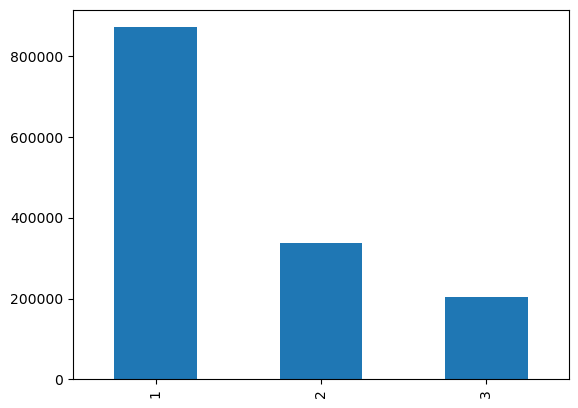

In [10]:
y_train.value_counts().plot(kind='bar')

##### <i> Naive Bayes is trained on 80% of training dataset without subsetting the data on 50000 records.

In [23]:
vectoriser = TfidfVectorizer()
X_train_vector = vectoriser.fit_transform(X_train)
X_test_vector = vectoriser.transform(X_test)

print(X_train.shape)
print(X_train_vector.shape)

print(X_test.shape)
print(X_test_vector.shape)

(1412849,)
(1412849, 120348)
(353213,)
(353213, 120348)


In [12]:
# list(vectoriser.get_feature_names_out())[-1000:]

In [13]:
# pd.DataFrame(X_train_vector.toarray(),columns=vectoriser.get_feature_names())

In [14]:
params = {'alpha': [0.0001,0.001,0.01,0.1,0.2,0.3,0.5]}

mnb = MultinomialNB()

grid = GridSearchCV(estimator=mnb,
                    param_grid=params,
                    scoring='accuracy',
                    cv=3,
                    return_train_score=True,
                    n_jobs=1,
                    verbose=3)

grid.fit(X_train_vector,y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END ..alpha=0.0001;, score=(train=0.769, test=0.735) total time=   0.9s
[CV 2/3] END ..alpha=0.0001;, score=(train=0.767, test=0.737) total time=   0.8s
[CV 3/3] END ..alpha=0.0001;, score=(train=0.774, test=0.734) total time=   0.9s
[CV 1/3] END ...alpha=0.001;, score=(train=0.769, test=0.735) total time=   0.9s
[CV 2/3] END ...alpha=0.001;, score=(train=0.767, test=0.738) total time=   0.9s
[CV 3/3] END ...alpha=0.001;, score=(train=0.774, test=0.735) total time=   0.9s
[CV 1/3] END ....alpha=0.01;, score=(train=0.768, test=0.736) total time=   0.9s
[CV 2/3] END ....alpha=0.01;, score=(train=0.766, test=0.738) total time=   0.9s
[CV 3/3] END ....alpha=0.01;, score=(train=0.773, test=0.738) total time=   0.9s
[CV 1/3] END .....alpha=0.1;, score=(train=0.763, test=0.736) total time=   0.9s
[CV 2/3] END .....alpha=0.1;, score=(train=0.762, test=0.738) total time=   0.9s
[CV 3/3] END .....alpha=0.1;, score=(train=0.770,

GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [18]:
df = pd.DataFrame(grid.cv_results_)
print(df.shape)
df.head(10)

(7, 17)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.789294,0.071072,0.156801,0.017170,0.0001,{'alpha': 0.0001},0.734906,0.737138,0.734430,0.735491,0.001180,6,0.769005,0.767383,0.774193,0.770193,0.002904
1,0.816152,0.022430,0.169019,0.025222,0.001,{'alpha': 0.001},0.735201,0.737509,0.735398,0.736036,0.001045,5,0.768793,0.767195,0.773953,0.769980,0.002884
2,0.832807,0.041801,0.173710,0.021413,0.01,{'alpha': 0.01},0.735838,0.738193,0.737791,0.737274,0.001029,3,0.767976,0.766348,0.773261,0.769195,0.002951
3,0.808803,0.039128,0.175162,0.027980,0.1,{'alpha': 0.1},0.735851,0.738267,0.741335,0.738484,0.002244,1,0.763139,0.761616,0.769576,0.764777,0.003450
4,0.811964,0.038627,0.180698,0.018939,0.2,{'alpha': 0.2},0.734698,0.737049,0.742046,0.737931,0.003064,2,0.758789,0.757447,0.766586,0.760941,0.004029
5,0.848601,0.109860,0.175050,0.030790,0.3,{'alpha': 0.3},0.733127,0.735382,0.741605,0.736704,0.003585,4,0.754878,0.753685,0.763852,0.757472,0.004538
6,0.827645,0.032135,0.172932,0.022039,0.5,{'alpha': 0.5},0.729727,0.731500,0.739318,0.733515,0.004167,7,0.747890,0.746628,0.758352,0.750957,0.005255


In [16]:
grid.best_estimator_

MultinomialNB(alpha=0.1)

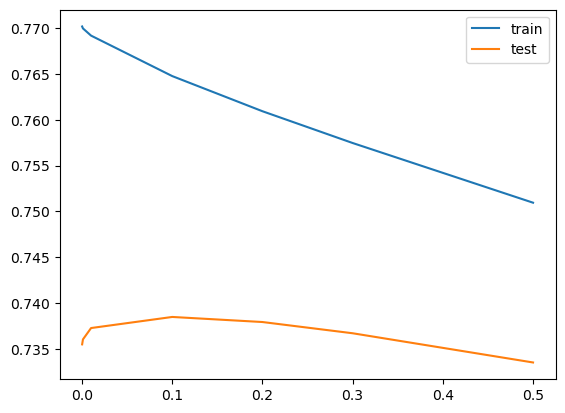

In [19]:
plt.plot(df.param_alpha,df.mean_train_score,label='train')
plt.plot(df.param_alpha,df.mean_test_score,label='test')
plt.legend()

In [20]:
mnb = MultinomialNB(alpha=0.1)

mnb.fit(X_train_vector,y_train)

MultinomialNB(alpha=0.1)

In [22]:
#on Train set

y_train_pred = mnb.predict(X_train_vector)

print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           1       0.77      0.96      0.86    870691
           2       0.65      0.38      0.48    337463
           3       0.83      0.56      0.67    204695

    accuracy                           0.76   1412849
   macro avg       0.75      0.63      0.67   1412849
weighted avg       0.75      0.76      0.74   1412849



In [23]:
#on Train set

y_test_pred = mnb.predict(X_test_vector)

print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           1       0.75      0.94      0.83    209766
           2       0.59      0.37      0.45     92450
           3       0.81      0.50      0.62     50997

    accuracy                           0.73    353213
   macro avg       0.71      0.60      0.64    353213
weighted avg       0.71      0.73      0.70    353213



### Using BERT Embeddings

In [12]:
# !pip install transformers[torch]
!conda env list

# conda environments:
#
base                     C:\Users\taran\anaconda3
deeplearning          *  C:\Users\taran\anaconda3\envs\deeplearning



In [35]:
import torch
import transformers
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

import accelerate
print(accelerate.__version__)
print(transformers.__version__)

0.27.2
4.36.2


In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [32]:
if torch.cuda.is_available():
    print("CUDA is available!")
    print(torch.cuda.device_count())
else:
    print("CUDA is not available.")
    
model.to('cuda')

CUDA is available!
1


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [33]:
max([len(doc) for doc in X_train])

6415

{'whiskers': [<matplotlib.lines.Line2D at 0x154d5c5b910>,
 'caps': [<matplotlib.lines.Line2D at 0x154d5c12a50>,
 'boxes': [<matplotlib.lines.Line2D at 0x154d5c441d0>],
 'medians': [<matplotlib.lines.Line2D at 0x154d72e3c50>],
 'fliers': [<matplotlib.lines.Line2D at 0x154d5c52ed0>],
 'means': []}

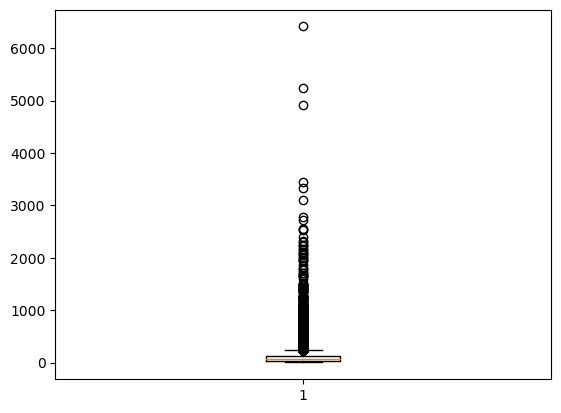

In [15]:
plt.boxplot([len(doc) for doc in X_train])

In [15]:
sample_data = [X_train[0]]
tokenizer(sample_data, padding=True, truncation=True, max_length=512)

{'input_ids': [[101, 2664, 4929, 3300, 2721, 2278, 3653, 6916, 2066, 6652, 2806, 2298, 2293, 2028, 3384, 22476, 12922, 10634, 8782, 3609, 2191, 2298, 6652, 3424, 28940, 3976, 2157, 1999, 10288, 11837, 2015, 13358, 2615, 2165, 2146, 2051, 8116, 2072, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [17]:
%%time
X_train_tokenized = tokenizer(list(X_train), padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(list(X_test), padding=True, truncation=True, max_length=512)

CPU times: total: 50.7 s
Wall time: 1min 5s


In [41]:
print(X_train_tokenized['input_ids'][0])

[101, 2664, 4929, 3300, 2721, 2278, 3653, 6916, 2066, 6652, 2806, 2298, 2293, 2028, 3384, 22476, 12922, 10634, 8782, 3609, 2191, 2298, 6652, 3424, 28940, 3976, 2157, 1999, 10288, 11837, 2015, 13358, 2615, 2165, 2146, 2051, 8116, 2072, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [35]:
print(X_train_tokenized['attention_mask'][0])

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [2]:
# X_train_tokenized['input_ids']

In [37]:
# create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])
     

train_dataset = Dataset(X_train_tokenized, list(y_train))
val_dataset = Dataset(X_test_tokenized, list(y_test))

In [38]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [39]:

args = TrainingArguments(
    output_dir="output",
    num_train_epochs=2,
    per_device_train_batch_size=8

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [40]:
train_dataset[0]

{'input_ids': tensor([ 101, 2293,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0, 

In [41]:
trainer.train()

Step,Training Loss
500,0.633800
1000,0.582400


KeyboardInterrupt: 

Area of Improvements:

- The Initial 3 classes can be balanced by upsampling the minority class using the synonyms of particular token identified by POS tagging.

- Currently, I have choosen evaluation metris as accuracy which doesn't identify the robustness for our given problem considering we are dealing with highly imbalanced dataset. it becomes cruicial to take care of the Negatives or Neutral reviews so that we can work on them. Hence, Recall would be a good metric for each of the classes.

- In Data preparation, We can discard the garbage tokens.

- Could use Lemmatization instead of Stemming after tagging each of the token with appropriate part of speech as Lemmatization works better given the pos of the token.

- Could try different algorithms like Random Forest or Adaboost which could take care of Imbalanceness of data as well.

- Could use more larger lenght of the BERT embedding. 

- Could tune the learning rate as part of training arguements in BERT model. This will make us to increase the number of epochs Hence the longer time to run.

Focusing on robust model given certain limitation is difficult in this study. such as Machine limitations given the size of dataset.

In [49]:
url = "https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz"

In [55]:
import pandas as pd

data = pd.read_csv("data.csv")

print(data.shape)
data.head()


(13, 2)


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1.0
1,OK... so... I really like Kris Kristofferson a...,0.0
2,"***SPOILER*** Do not read this, if you think a...",0.0
3,hi for all the people who have seen this wonde...,1.0
4,"I recently bought the DVD, forgetting just how...",0.0


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review     13 non-null     object 
 1   sentiment  12 non-null     float64
dtypes: float64(1), object(1)
memory usage: 340.0+ bytes


In [69]:
"not" in stopwords.words('english')

True

In [72]:
data.sentiment[:10].

0    1.0
1    0.0
2    0.0
3    1.0
4    0.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: sentiment, dtype: float64

In [76]:
msg = [doc.lower() for doc in data.review.to_list()]


X_train = msg[:10]
y_train = data.sentiment[:10].to_list()

X_test = msg[10:]
y_test = data.sentiment[10:].to_list()

# print(X_train)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)


In [79]:

# [token for doc in msg for token in doc.split()]
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow import keras

# Tokenizer.fit_transform(msg)
# 

100, 10

In [ ]:
model = keras.Sequential(input=(100, 10))

model.add()